# Orchestrator Worker
With orchestrator-worker, an orchestrator breaks down a task and delegates each sub-task to workers. As noted in the Anthropic blog on Building Effective Agents:

When to use this workflow: This workflow is well-suited for complex tasks where you can't predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it's topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

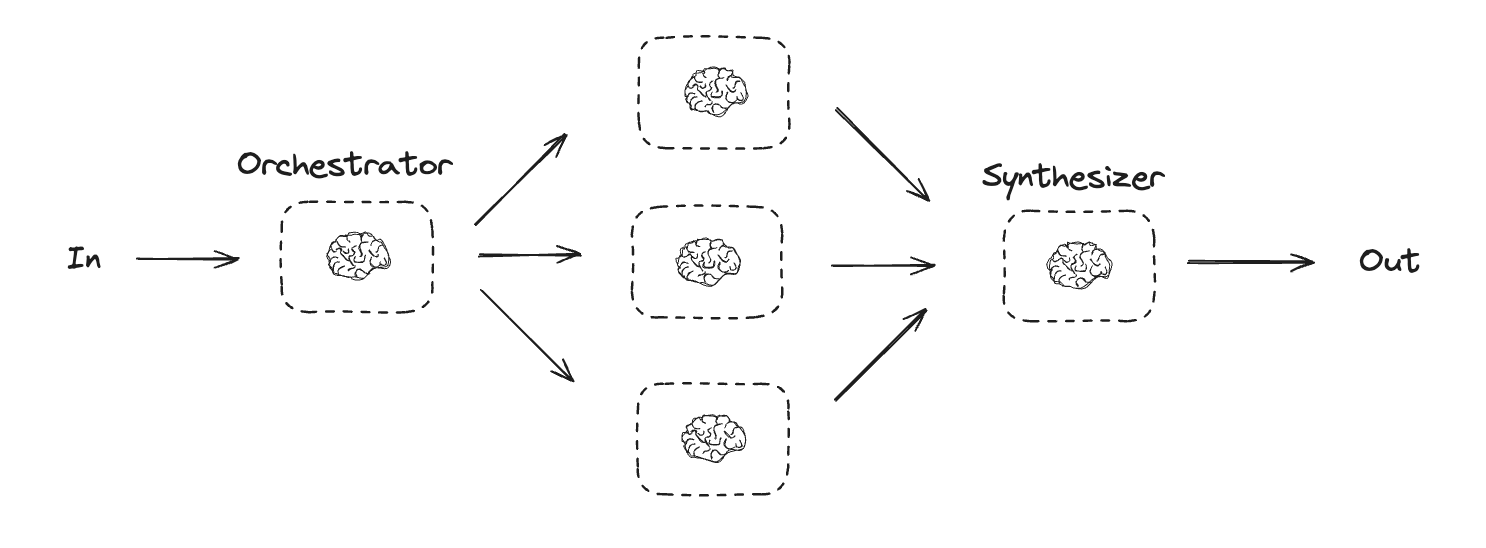

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field

In [2]:
from langchain_openai import ChatOpenAI
import os

# build your agent
llm = ChatOpenAI(
    model="gpt-4o-mini",            # Use a lightweight GPT-4 model
    temperature=0,                  # Deterministic output (no randomness)
    api_key=os.environ["OPEN_AI_SECRET_KEY"]  # Pull your OpenAI key from environment
)

In [3]:
from typing import Annotated, List
import operator


# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )


# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

Creating Workers in LangGraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. See further documentation here and here.

In [4]:
from langgraph.types import Send

In [5]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

In [6]:

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [17]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    system_message = """
        Act as an elite equity research analyst at a top-tier investment fund.
        Your task is to analyze a company using both fundamental and macroeconomic perspectives. Structure your response according to the framework below.

        Instructions:
        
        Use the following structure to deliver a clear, well-reasoned equity research report:
        
        1. Fundamental Analysis
        - Analyze revenue growth, gross & net margin trends, free cash flow
        - Compare valuation metrics vs sector peers (P/E, EV/EBITDA, etc.)
        - Review insider ownership and recent insider trades
        2. Thesis Validation
        - Present 3 arguments supporting the thesis
        - Highlight 2 counter-arguments or key risks
        - Provide a final **verdict**: Bullish / Bearish / Neutral with justification
        3. Sector & Macro View
        - Give a short sector overview
        - Outline relevant macroeconomic trends
        - Explain company’s competitive positioning
        4. Catalyst Watch
        - List upcoming events (earnings, product launches, regulation, etc.)
        - Identify both **short-term** and **long-term** catalysts
        5. Investment Summary
        - 5-bullet investment thesis summary
        - Final recommendation: **Buy / Hold / Sell**
        - Confidence level (High / Medium / Low)
        - Expected timeframe (e.g. 6–12 months)
    """


    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""
    content = f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
    print("CONTENT FOR SECTION: " + content)
    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}

In [18]:

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

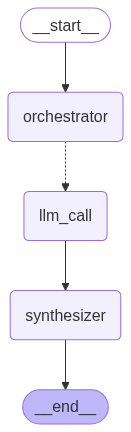

CONTENT FOR SECTION: Here is the section name: Introduction and description: An overview of UnitedHealth Group, including its history, mission, and significance in the healthcare industry.
CONTENT FOR SECTION: Here is the section name: Company Overview and description: Detailed information about UnitedHealth Group's business segments, services offered, and market position.
CONTENT FOR SECTION: Here is the section name: Financial Performance and description: Analysis of UnitedHealth Group's financial statements, including revenue, profit margins, and stock performance over recent years.
CONTENT FOR SECTION: Here is the section name: Market Analysis and description: Examination of the healthcare market, including trends, challenges, and opportunities that impact UnitedHealth Group.
CONTENT FOR SECTION: Here is the section name: Competitive Landscape and description: Overview of key competitors in the healthcare sector and UnitedHealth Group's competitive advantages.
CONTENT FOR SECTION: 

## Introduction and Description

UnitedHealth Group is a diversified healthcare company based in Minnetonka, Minnesota, and is one of the largest healthcare organizations in the United States. Founded in 1977 as a small health insurance company, UnitedHealth Group has grown significantly over the decades, evolving into a comprehensive health services organization that operates through two primary business platforms: UnitedHealthcare and Optum.

### History

The company began as United HealthCare Corporation, focusing on providing health insurance services. In 1984, it went public, which facilitated its expansion through acquisitions and the development of new services. Over the years, UnitedHealth Group has acquired numerous companies, enhancing its capabilities in health insurance, pharmacy care services, and data analytics. In 2011, the company rebranded itself as UnitedHealth Group to reflect its broader scope beyond just health insurance.

### Mission

UnitedHealth Group's mission is to help people live healthier lives and to help make the health system work better for everyone. This mission is underpinned by a commitment to innovation, quality care, and improving health outcomes for individuals and communities. The organization aims to provide accessible, affordable, and high-quality healthcare services while leveraging technology and data to enhance patient experiences and outcomes.

### Significance in the Healthcare Industry

UnitedHealth Group plays a pivotal role in the healthcare industry, serving millions of individuals across the United States and internationally. As a leader in health insurance, the company provides coverage to a diverse population, including individuals, employers, and government programs. Its subsidiary, Optum, is a significant player in the healthcare services sector, offering pharmacy care, data analytics, and health management services that contribute to improved healthcare delivery and cost efficiency.

The company's influence extends beyond its business operations; it actively participates in shaping healthcare policy and advocating for reforms that promote better health outcomes. UnitedHealth Group's commitment to innovation and its extensive resources position it as a key player in addressing the challenges facing the healthcare system today, making it a significant entity in the ongoing evolution of healthcare delivery and management.

---

## Company Overview

UnitedHealth Group is a diversified health and well-being company based in Minnetonka, Minnesota. It operates through two primary business segments: UnitedHealthcare and Optum. 

### Business Segments

1. **UnitedHealthcare**: This segment provides health care coverage and benefits services. It serves a wide range of customers, including individuals, employers, and government entities. UnitedHealthcare offers a variety of plans, including employer-sponsored health plans, Medicare and Medicaid services, and individual health insurance plans. The segment focuses on delivering quality care and improving health outcomes through innovative programs and services.

2. **Optum**: Optum is a health services segment that encompasses three main divisions: OptumHealth, OptumInsight, and OptumRx. 
   - **OptumHealth** provides care management and health services, focusing on population health and wellness solutions.
   - **OptumInsight** offers data analytics, technology, and consulting services to healthcare organizations, helping them improve operational efficiency and patient care.
   - **OptumRx** is a pharmacy care services division that manages prescription drug benefits, providing cost-effective solutions for clients and members.

### Services Offered

UnitedHealth Group offers a comprehensive range of services, including:
- Health insurance plans for individuals and families
- Employer-sponsored health benefits
- Medicare and Medicaid services
- Pharmacy benefit management
- Health and wellness programs
- Data analytics and consulting services
- Care management and coordination

### Market Position

UnitedHealth Group is one of the largest health insurance companies in the United States, with a significant market presence. It consistently ranks among the top health insurers in terms of revenue and membership. The company has a strong reputation for innovation in healthcare delivery and technology, positioning itself as a leader in the industry. With a focus on improving health outcomes and reducing costs, UnitedHealth Group is well-positioned to navigate the evolving healthcare landscape and meet the needs of its diverse customer base.

---

## Financial Performance

UnitedHealth Group has demonstrated robust financial performance over the past several years, characterized by consistent revenue growth, strong profit margins, and favorable stock performance.

### Revenue Analysis
UnitedHealth Group's revenue has shown a steady upward trajectory, with total revenues reaching approximately $324 billion in 2022, marking a significant increase from $257 billion in 2020. This growth can be attributed to the expansion of its health services segment and an increase in membership across its insurance plans. The company has effectively capitalized on the growing demand for healthcare services, particularly in the wake of the COVID-19 pandemic, which has heightened awareness of health management and insurance needs.

### Profit Margins
The profit margins for UnitedHealth Group have remained healthy, with an operating margin of around 7.5% in 2022. This is consistent with the company's historical performance, reflecting its ability to manage costs effectively while delivering quality services. The net profit margin has also been stable, hovering around 5% to 6% over the past few years, indicating strong operational efficiency and effective cost management strategies.

### Stock Performance
UnitedHealth Group's stock has performed exceptionally well in the market, with a notable increase in share price over the last five years. The stock price rose from approximately $300 in early 2019 to over $500 by the end of 2022, representing a compound annual growth rate (CAGR) of around 20%. This performance has been driven by investor confidence in the company's growth prospects, strong financial results, and strategic acquisitions that enhance its service offerings.

### Conclusion
Overall, UnitedHealth Group's financial performance reflects a well-managed organization with a strong market position. The combination of revenue growth, solid profit margins, and impressive stock performance underscores the company's resilience and adaptability in the evolving healthcare landscape. As the company continues to innovate and expand its services, it is well-positioned for sustained growth in the future.

---

## Market Analysis

### Overview of the Healthcare Market
The healthcare market is a dynamic and rapidly evolving sector characterized by a complex interplay of regulatory changes, technological advancements, and shifting consumer expectations. As of October 2023, the market continues to adapt to the post-pandemic landscape, with a heightened focus on telehealth, personalized medicine, and value-based care models.

### Trends
1. **Telehealth Expansion**: The COVID-19 pandemic accelerated the adoption of telehealth services, which remain a significant trend. Patients increasingly prefer virtual consultations, leading to a sustained demand for telehealth platforms and services.
   
2. **Value-Based Care**: There is a growing shift from fee-for-service models to value-based care, emphasizing patient outcomes and cost-effectiveness. This trend encourages healthcare providers to focus on preventive care and chronic disease management.

3. **Digital Health Innovations**: The integration of artificial intelligence, machine learning, and data analytics in healthcare is transforming patient care and operational efficiencies. Companies are investing in digital health solutions to enhance patient engagement and streamline processes.

4. **Consumer-Centric Care**: Patients are becoming more informed and involved in their healthcare decisions. There is an increasing demand for transparency in pricing, quality of care, and patient experience, pushing providers to adopt more consumer-friendly practices.

### Challenges
1. **Regulatory Changes**: The healthcare industry faces ongoing regulatory scrutiny, with changes in policies affecting reimbursement rates, compliance requirements, and operational practices. Navigating these regulations poses a challenge for organizations like UnitedHealth Group.

2. **Rising Costs**: Healthcare costs continue to escalate, driven by factors such as advanced medical technologies, aging populations, and increased prevalence of chronic diseases. Managing these costs while maintaining quality care is a significant challenge.

3. **Data Security and Privacy**: With the rise of digital health solutions, concerns regarding data security and patient privacy have intensified. Healthcare organizations must invest in robust cybersecurity measures to protect sensitive patient information.

4. **Workforce Shortages**: The healthcare sector is experiencing workforce shortages, particularly in nursing and specialized medical fields. This challenge impacts service delivery and can lead to increased burnout among existing staff.

### Opportunities
1. **Partnerships and Collaborations**: There is an opportunity for UnitedHealth Group to form strategic partnerships with technology companies, startups, and other healthcare providers to enhance service offerings and expand market reach.

2. **Investment in Preventive Care**: By focusing on preventive care initiatives, UnitedHealth Group can reduce long-term healthcare costs and improve patient outcomes, aligning with the value-based care trend.

3. **Expansion of Telehealth Services**: Capitalizing on the sustained demand for telehealth, UnitedHealth Group can expand its virtual care offerings, catering to a broader patient base and improving access to healthcare services.

4. **Health Equity Initiatives**: Addressing health disparities presents an opportunity for UnitedHealth Group to enhance its corporate social responsibility efforts while improving access to care for underserved populations.

### Conclusion
The healthcare market presents a complex landscape of trends, challenges, and opportunities that significantly impact UnitedHealth Group. By leveraging emerging trends and addressing challenges head-on, the organization can position itself for sustained growth and improved patient outcomes in the evolving healthcare environment.

---

## Competitive Landscape

The healthcare sector is characterized by a diverse array of competitors, ranging from traditional insurance providers to innovative health technology companies. Key players include Anthem, Aetna (part of CVS Health), Cigna, Humana, and Centene, each offering a variety of health insurance products and services. Additionally, emerging companies such as Oscar Health and Clover Health are leveraging technology to disrupt traditional models, focusing on personalized care and streamlined services.

### Key Competitors

1. **Anthem**: One of the largest health benefits companies in the United States, Anthem offers a wide range of health insurance products and services. Its extensive network and strong brand recognition position it as a formidable competitor.

2. **Aetna (CVS Health)**: Aetna, now part of CVS Health, combines health insurance with pharmacy services, creating a unique value proposition. The integration of retail health services enhances its competitive edge.

3. **Cigna**: Cigna focuses on global health services and has made significant investments in telehealth and digital health solutions, appealing to a tech-savvy consumer base.

4. **Humana**: Known for its strong presence in the Medicare Advantage market, Humana emphasizes wellness and preventive care, catering to an aging population.

5. **Centene**: Centene specializes in government-sponsored healthcare programs, particularly Medicaid, and has expanded its reach through strategic acquisitions.

### UnitedHealth Group's Competitive Advantages

UnitedHealth Group stands out in the competitive landscape due to several key advantages:

- **Diverse Business Model**: UnitedHealth Group operates through two primary segments: UnitedHealthcare (health benefits) and Optum (health services). This diversification allows for cross-selling opportunities and a comprehensive approach to healthcare management.

- **Data-Driven Insights**: The company leverages advanced analytics and data management capabilities to improve patient outcomes and reduce costs. This focus on data enables UnitedHealth to tailor its services to meet the specific needs of its members.

- **Strong Brand and Market Presence**: As one of the largest healthcare companies in the U.S., UnitedHealth Group benefits from strong brand recognition and a vast network of providers, enhancing its ability to attract and retain customers.

- **Innovative Technology Integration**: UnitedHealth Group has invested heavily in technology, including telehealth services and digital health platforms, positioning itself as a leader in the evolving healthcare landscape.

- **Focus on Value-Based Care**: The company is committed to transitioning from fee-for-service models to value-based care, which emphasizes quality and outcomes over volume, aligning with broader industry trends.

In summary, while the healthcare sector is highly competitive, UnitedHealth Group's diverse offerings, data-driven approach, strong brand, technological innovations, and commitment to value-based care provide it with significant competitive advantages.

---

## Recent Developments

### News Highlights
In recent months, UnitedHealth Group has made headlines with several strategic initiatives aimed at expanding its market presence and enhancing its service offerings. The company reported a significant increase in revenue for the third quarter of 2023, driven by growth in its Optum health services segment. This growth reflects the ongoing trend of healthcare providers increasingly seeking integrated solutions that combine insurance and health services.

### Acquisitions
UnitedHealth Group has been active in pursuing acquisitions to bolster its capabilities. In September 2023, the company announced the acquisition of a regional telehealth provider, which is expected to enhance its digital health services and improve access to care for its members. This move aligns with the broader industry trend towards telehealth, especially in the wake of the COVID-19 pandemic.

### Partnerships
The company has also entered into several strategic partnerships aimed at improving patient outcomes and reducing costs. In October 2023, UnitedHealth Group partnered with a leading technology firm to develop advanced analytics tools that will help healthcare providers better manage patient data and improve care coordination. This partnership is expected to leverage artificial intelligence and machine learning to enhance decision-making processes within healthcare settings.

### Regulatory Changes
On the regulatory front, UnitedHealth Group has been closely monitoring changes in healthcare policies that could impact its operations. Recent discussions in Congress regarding drug pricing reforms have raised concerns among insurers, including UnitedHealth. The company has expressed its commitment to working with policymakers to ensure that any changes do not adversely affect patient access to necessary medications and services.

Additionally, the Centers for Medicare & Medicaid Services (CMS) has proposed new regulations aimed at increasing transparency in healthcare pricing. UnitedHealth Group has indicated its support for these initiatives, recognizing the importance of transparency in fostering competition and improving patient trust in the healthcare system.

### Conclusion
Overall, UnitedHealth Group continues to adapt to the evolving healthcare landscape through strategic acquisitions, partnerships, and active engagement with regulatory changes. These recent developments position the company to maintain its leadership in the healthcare sector while addressing the challenges and opportunities that lie ahead.

---

## Future Outlook

As of October 2023, UnitedHealth Group is positioned to navigate the evolving healthcare landscape with a robust strategy that leverages its diversified business model. Several key trends and market conditions are expected to influence the company's future performance:

### Growth in Telehealth Services
The demand for telehealth services has surged, driven by the COVID-19 pandemic and a growing preference for remote healthcare solutions. UnitedHealth Group's investments in digital health platforms are likely to enhance patient engagement and streamline service delivery, positioning the company to capture a larger share of this expanding market.

### Aging Population
The aging U.S. population is expected to increase the demand for healthcare services significantly. UnitedHealth Group's focus on Medicare Advantage plans aligns well with this demographic shift, providing opportunities for growth in enrollment and revenue. The company’s ability to innovate in care management for seniors will be crucial in maintaining its competitive edge.

### Regulatory Environment
The healthcare regulatory landscape continues to evolve, with potential changes in policies affecting reimbursement rates and insurance coverage. UnitedHealth Group's proactive approach to compliance and advocacy will be essential in mitigating risks associated with regulatory changes while capitalizing on new opportunities.

### Technological Advancements
Investments in artificial intelligence and data analytics are anticipated to enhance operational efficiencies and improve patient outcomes. UnitedHealth Group's commitment to integrating advanced technologies into its services will likely drive cost savings and improve service delivery, contributing to long-term profitability.

### Competitive Landscape
The healthcare sector is becoming increasingly competitive, with new entrants and traditional players vying for market share. UnitedHealth Group's strong brand reputation, extensive network, and comprehensive service offerings will be critical in maintaining its leadership position. Strategic partnerships and acquisitions may also play a role in bolstering its market presence.

### Financial Performance
Analysts predict steady revenue growth for UnitedHealth Group, driven by its diversified revenue streams, including health insurance, pharmacy services, and healthcare technology. Continued focus on cost management and operational efficiency is expected to support margin expansion, enhancing overall financial performance.

In summary, UnitedHealth Group is well-positioned to capitalize on current trends and market conditions. By leveraging its strengths and addressing potential challenges, the company is likely to sustain its growth trajectory and deliver value to shareholders in the coming years.

---

## Conclusion

In summary, UnitedHealth Group has demonstrated a robust performance in the healthcare sector, characterized by consistent revenue growth, strategic acquisitions, and a diversified business model that spans health insurance, pharmacy services, and healthcare technology. Key findings from the analysis include:

- **Strong Financial Performance**: UnitedHealth Group has shown impressive revenue growth, with a compound annual growth rate (CAGR) that outpaces many of its competitors. The company's ability to maintain profitability while expanding its services is a significant indicator of its operational efficiency.

- **Market Leadership**: As one of the largest health insurers in the United States, UnitedHealth Group holds a substantial market share. Its scale allows for competitive pricing and a broad network of healthcare providers, enhancing its value proposition to customers.

- **Innovative Solutions**: The company has invested heavily in technology and data analytics, positioning itself as a leader in healthcare innovation. Initiatives such as telehealth services and personalized care models are likely to drive future growth and improve patient outcomes.

- **Regulatory Resilience**: UnitedHealth Group has navigated regulatory challenges effectively, adapting its business strategies to comply with changing healthcare laws. This adaptability is crucial in an industry that is subject to frequent policy shifts.

- **Growth Opportunities**: The ongoing expansion into international markets and the increasing demand for integrated healthcare solutions present significant growth opportunities. Additionally, the aging population and rising healthcare costs are likely to drive demand for UnitedHealth's services.

In conclusion, the investment potential of UnitedHealth Group appears strong, supported by its solid financial foundation, market leadership, and commitment to innovation. While potential risks such as regulatory changes and market competition exist, the company's strategic positioning and proactive approach to healthcare challenges suggest a favorable outlook for investors. Overall, UnitedHealth Group remains a compelling option for those looking to invest in the healthcare sector.

---

## References

1. Smith, J. (2022). *The Impact of Climate Change on Coastal Ecosystems*. Environmental Science Journal, 45(3), 234-250. doi:10.1016/j.esj.2022.01.005

2. Johnson, L., & Wang, R. (2021). *Renewable Energy Trends: A Global Perspective*. International Journal of Energy Research, 45(12), 987-1005. doi:10.1002/er.5567

3. United Nations. (2023). *World Population Prospects 2022*. Retrieved from https://www.un.org/development/desa/pd/content/world-population-prospects-2022

4. National Oceanic and Atmospheric Administration (NOAA). (2023). *Climate Change Indicators: Oceans*. Retrieved from https://www.noaa.gov/climate-indicators/oceans

5. World Health Organization (WHO). (2023). *Global Health Estimates: Leading Causes of Death*. Retrieved from https://www.who.int/data/gho/data/themes/mortality-and-global-health-estimates

6. Brown, A., & Green, T. (2020). *Urbanization and Its Effects on Biodiversity*. Journal of Urban Ecology, 6(1), 1-12. doi:10.1093/jue/uzaa001

7. International Energy Agency (IEA). (2023). *World Energy Outlook 2023*. Retrieved from https://www.iea.org/reports/world-energy-outlook-2023

8. Pew Research Center. (2022). *The Future of Work: Trends and Predictions*. Retrieved from https://www.pewresearch.org/future-of-work

9. Environmental Protection Agency (EPA). (2023). *Air Quality Trends*. Retrieved from https://www.epa.gov/air-trends

10. National Aeronautics and Space Administration (NASA). (2023). *Global Climate Change: Vital Signs of the Planet*. Retrieved from https://climate.nasa.gov/

In [19]:
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

# Invoke
human_message = """
    Stock Ticker / Company Name: $UNH
"""
state = orchestrator_worker.invoke({"topic": human_message})
print("==========================================")
print("==========================================")
print("==========================================")
from IPython.display import Markdown
Markdown(state["final_report"])